In [1]:
import os
import sys
import numpy as np
import importlib
import argparse
from tqdm import tqdm

import torch

from nerv.utils import AverageMeter, save_video
from nerv.training import BaseDataModule

from vp_utils import (
    pred_eval_step,
    postproc_mask,
    masks_to_boxes,
    PALETTE_torch,
)
from vp_vis import make_video, batch_draw_bbox
from models import build_model
from datasets import build_dataset

import lpips

loss_fn_vgg = lpips.LPIPS(net="vgg")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/users/ejlaird/.conda/envs/slotformer/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/ejlaird/.conda/envs/slotformer/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /users/ejlaird/.conda/envs/slotformer/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


/users/ejlaird/.conda/envs/slotformer/lib/python3.8/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_pat

In [2]:
def _save_video(params, args, videos, video_fn, dim=3):
    """Save torch tensors to a video."""
    video = torch.cat(videos, dim=dim)  # [T, 3, 2*H, B*W]
    video = (video * 255.0).numpy().astype(np.uint8)
    save_path = os.path.join(
        "vis", params.dataset.split("_")[0], args.params, video_fn
    )
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    save_video(video, save_path, fps=4)


def adjust_params(params, batch_size):
    """Adjust config files for testing."""
    if batch_size > 0:
        params.val_batch_size = batch_size
    else:
        params.val_batch_size = 12 if "obj3d" in params.dataset.lower() else 8

    # rollout the model until 50 steps for OBJ3D dataset
    if "obj3d" in params.dataset.lower():
        num_frames = 50
    # rollout the model until 48 steps for CLEVRER dataset
    elif "clevrer" in params.dataset.lower():
        num_frames = 48
        params.load_mask = True  # test mask/bbox
    else:
        raise NotImplementedError("Unknown dataset: {}".format(params.dataset))

    params.n_sample_frames = num_frames
    if params.model == "SlotFormer":
        params.loss_dict["rollout_len"] = num_frames - params.input_frames
    else:
        raise NotImplementedError(f"Unknown model: {params.model}")

    # setup rollout image
    if params.model == "SlotFormer":
        params.loss_dict["use_img_recon_loss"] = True
    params.load_img = True

    return params


def get_input(params, data_dict):
    """Prepare burn-in frames/gt data."""
    history_len = params.input_frames
    rollout_len = params.n_sample_frames - history_len
    gt = data_dict["img"][:, history_len:]

    if "mask" in data_dict:
        gt_mask = data_dict["mask"][:, history_len:].long()
    else:
        gt_mask = None
    if "bbox" in data_dict:
        gt_bbox = data_dict["bbox"][:, history_len:]
        gt_pres_mask = data_dict["pres_mask"][:, history_len:].bool()
    else:
        gt_bbox, gt_pres_mask = None, None

    assert gt.shape[1] == rollout_len

    return gt, gt_mask, gt_bbox, gt_pres_mask


import numpy as np

import torch
from torchvision.ops import masks_to_boxes
import torchvision.transforms as transforms
from torchvision.transforms import functional as F

import pycocotools.mask as mask_utils


def compact(l):
    return list(filter(None, l))


class BaseTransforms(object):
    """Data pre-processing steps."""

    def __init__(self, resolution, mean=(0.5,), std=(0.5,)):
        self.transforms = transforms.Compose(
            [
                transforms.ToTensor(),  # [3, H, W]
                transforms.Normalize(mean, std),  # [-1, 1]
                transforms.Resize(resolution),
            ]
        )
        self.resolution = resolution

    def process_mask(self, mask):
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask).long()
        if len(mask.shape) == 2:
            mask = mask.unsqueeze(0)
            mask = F.resize(
                mask,
                self.resolution,
                interpolation=transforms.InterpolationMode.NEAREST,
            )[0]
        else:
            mask = F.resize(
                mask,
                self.resolution,
                interpolation=transforms.InterpolationMode.NEAREST,
            )
        return mask

    def __call__(self, input):
        return self.transforms(input)


def get_output(params, out_dict):
    """Extract outputs for evaluation."""
    history_len = params.input_frames
    rollout_len = params.n_sample_frames - history_len

    if params.model == "SlotFormer":
        pred = out_dict["recon_combined"]
        pred_mask = postproc_mask(out_dict["masks"])
        pred_bbox = masks_to_boxes(pred_mask, params.slot_dict["num_slots"])
    else:
        raise NotImplementedError(f"Unknown model: {params.model}")

    assert pred.shape[1] == rollout_len
    if pred_mask is not None:
        assert pred_mask.shape[1] == rollout_len
    if pred_bbox is not None:
        assert pred_bbox.shape[1] == rollout_len

    return pred, pred_mask, pred_bbox

In [3]:
from configs.slotformer_obj3d_params import SlotFormerParams

params = SlotFormerParams()
params = adjust_params(params, 1)

params.dataset = "obj3d_slots"
params.data_root = "/users/ejlaird/Projects/SlotFormer-experimental/data/OBJ3D"
params.slots_root = "/users/ejlaird/Projects/SlotFormer-experimental/data/OBJ3D/obj3d_slots.pkl"

In [4]:
val_set = build_dataset(params, val_only=True)

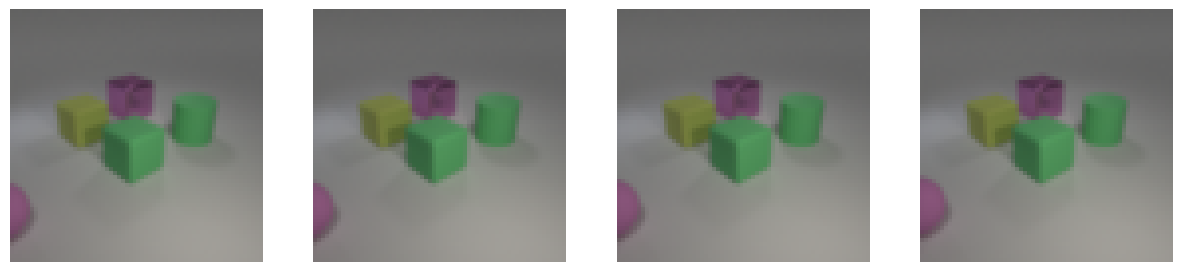

In [5]:
import matplotlib.pyplot as plt

# Assuming you have a dataset instance called 'dataset'
sample = val_set[0]  # Get first sample
frames = sample["img"]  # Shape: [T, 3, H, W]


def inverse_transform(frame):
    img = frame.permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    return img


# Plot a few frames
fig, axes = plt.subplots(1, min(4, frames.shape[0]), figsize=(15, 4))
for i, ax in enumerate(axes):
    # Convert tensor to numpy array and adjust dimensions/range for plotting
    img_np = inverse_transform(frames[i])
    ax.imshow(img_np)
    ax.axis("off")
plt.show()

## Load model


In [6]:
params.dec_dict["dec_ckp_path"] = (
    "/users/ejlaird/Projects/SlotFormer-experimental/pretrained/savi_obj3d_params/model_40.pth"
)
weight_path = "/users/ejlaird/Projects/SlotFormer-experimental/pretrained/slotformer_obj3d_params/model_200.pth"
model = build_model(params).eval()
model.load_state_dict(
    torch.load(weight_path, map_location="cpu", weights_only=True)[
        "state_dict"
    ]
)

/users/ejlaird/.conda/envs/slotformer/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [7]:
model.rollouter.transformer_encoder.layers[0].self_attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
)

In [8]:
datamodule = BaseDataModule(
    params, train_set=val_set, val_set=val_set, use_ddp=False
)
val_loader = datamodule.val_loader

In [9]:
test_dict = next(iter(val_loader))
out_dict = model(test_dict)
out_dict.keys()

saved attention weights: 176


dict_keys(['recon_combined', 'recons', 'masks', 'attention_weights', 'intra_timestep_weights', 'pred_slots', 'gt_slots'])

In [11]:
out_dict["intra_timestep_weights"][0]

tensor([[[[0.0721, 0.0039, 0.1589, 0.0039, 0.0027, 0.0063],
          [0.0128, 0.0086, 0.2174, 0.0058, 0.0068, 0.0072],
          [0.0027, 0.0031, 0.2676, 0.0019, 0.0088, 0.0059],
          [0.0019, 0.0025, 0.2387, 0.0065, 0.0021, 0.0029],
          [0.0044, 0.0054, 0.2596, 0.0064, 0.0162, 0.0112],
          [0.0011, 0.0045, 0.2616, 0.0022, 0.0022, 0.0075]]]],
       grad_fn=<UnsqueezeBackward0>)

In [13]:
out_dict["pred_slots"].shape

torch.Size([1, 44, 6, 128])

In [69]:
recon_combined, recons = (
    out_dict["recon_combined"],
    out_dict["recons"],
)
recon_combined.shape, recons.shape

(torch.Size([1, 44, 3, 64, 64]), torch.Size([1, 44, 6, 3, 64, 64]))

In [36]:
from matplotlib import animation
from IPython.display import HTML


# def create_video_player(frames, attention_weights, fps=10, figsize=(16, 8)):
#     """
#     Create a video player for frames and attention weights side by side.

#     Args:
#         frames: Tensor of shape [T, C, H, W] or [B, T, C, H, W]
#         attention_weights: List of attention weight tensors
#         fps: Frames per second
#         figsize: Figure size in inches
#     """
#     # Remove batch dimension if present
#     if len(frames.shape) == 5:
#         frames = frames.squeeze(0)

#     # Convert frames to numpy and transform
#     frames = [inverse_transform(frame) for frame in frames]

#     # Process attention weights for each timestep
#     attentions = [
#         w.squeeze().squeeze().detach().numpy() for w in attention_weights
#     ]

#     # Create figure with two subplots side by side
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

#     # Initialize both plots
#     im1 = ax1.imshow(frames[0])
#     im2 = ax2.imshow(attentions[0], cmap="viridis")

#     ax1.axis("off")
#     ax2.set_title("Attention Matrix")

#     # Add colorbar for attention plot
#     plt.colorbar(im2, ax=ax2)

#     def animate(i):
#         # Update both frame and attention matrix
#         im1.set_array(frames[i])
#         im2.set_array(attentions[i])
#         return [im1, im2]

#     anim = animation.FuncAnimation(
#         fig,
#         animate,
#         frames=min(
#             len(frames), len(attentions)
#         ),  # Use shorter length to be safe
#         interval=1000 / fps,  # interval in milliseconds
#         blit=True,
#     )


#     plt.close()
#     return anim


def create_video_player(
    frames, attention_weights, masks, fps=10, figsize=(20, 8)
):
    """
    Create a video player showing frames with mask overlays and attention weights.

    Args:
        frames: Tensor of shape [T, C, H, W] or [B, T, C, H, W]
        attention_weights: List of attention weight tensors
        masks: Tensor of shape [B, T, num_slots, 1, H, W]
        fps: Frames per second
        figsize: Figure size in inches
    """
    # Remove batch dimension if present
    if len(frames.shape) == 5:
        frames = frames.squeeze(0)
    if len(masks.shape) == 6:
        masks = masks.squeeze(0)

    num_slots = masks.shape[1]

    # Convert frames to numpy and transform
    frames = [inverse_transform(frame) for frame in frames]

    # Process attention weights for each timestep
    attentions = [w.squeeze().detach().numpy() for w in attention_weights]

    # Process masks
    masks = masks.squeeze(3).detach().numpy()  # Shape: [T, num_slots, H, W]

    # Create visualization arrays for each slot
    slot_vis = []
    for t in range(len(frames)):
        time_vis = []
        for slot in range(num_slots):
            # Create RGBA image
            rgba = np.zeros(frames[t].shape[:-1] + (4,))  # Shape: [H, W, 4]
            rgba[..., :3] = frames[t]  # RGB channels from original frame
            rgba[..., 3] = masks[t, slot]  # Alpha channel from mask
            time_vis.append(rgba)
        slot_vis.append(time_vis)

    # Create figure with grid layout
    fig = plt.figure(figsize=figsize)
    gs = plt.GridSpec(2, num_slots + 2)

    # Main frame and attention axes
    ax_frame = fig.add_subplot(gs[0, 0])
    ax_attn = fig.add_subplot(gs[0, 1])

    # Slot visualization axes
    ax_slots = []
    for i in range(num_slots):
        ax = fig.add_subplot(gs[1, i])
        ax_slots.append(ax)
        ax.axis("off")
        ax.set_title(f"Slot {i}")

    # Initialize plots
    im_frame = ax_frame.imshow(frames[0])
    im_attn = ax_attn.imshow(attentions[0], cmap="viridis")

    # Initialize slot visualizations
    im_slots = []
    for i in range(num_slots):
        im = ax_slots[i].imshow(slot_vis[0][i])
        im_slots.append(im)

    ax_frame.axis("off")
    ax_frame.set_title("Frame")
    ax_attn.set_title("Attention Matrix")

    # Add colorbar for attention plot
    plt.colorbar(im_attn, ax=ax_attn)

    def animate(t):
        # Update frame
        im_frame.set_array(frames[t])
        # Update attention
        im_attn.set_array(attentions[t])
        # Update slots
        for i in range(num_slots):
            im_slots[i].set_array(slot_vis[t][i])

        return [im_frame, im_attn] + im_slots

    anim = animation.FuncAnimation(
        fig,
        animate,
        frames=min(len(frames), len(attentions), len(slot_vis)),
        interval=1000 / fps,
        blit=True,
    )

    plt.tight_layout()
    plt.close()
    return anim

In [37]:
recon_combined, attention_weights, masks = (
    out_dict["recon_combined"].detach().squeeze(0),
    out_dict["intra_timestep_weights"],
    out_dict["masks"],
)

In [38]:
# For your recon_combined tensor:
anim = create_video_player(recon_combined, attention_weights, masks, fps=10)
display(HTML(anim.to_jshtml()))

In [40]:
len(out_dict["attention_weights"])

176

In [29]:
out_dict["recons"].shape

torch.Size([1, 44, 6, 3, 64, 64])